In [55]:
!pip install pandas requests lxml html5lib beautifulsoup4

In [56]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [57]:
mb_stats_2024_25_url = 'https://www.espn.com/nba/team/stats/_/name/mil/milwaukee-bucks'

nba_standings_2024_25 = "https://www.espn.com/nba/standings"

nba_standings_2024_25_league = "https://www.espn.com/nba/standings/_/group/league"

nba_standings_2023_24_league = "https://www.espn.com/nba/standings/_/season/2024/group/league"

extra_data_milwaukee_bucks = "https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/table/game/ordenar/gamesPlayed/dir/desce"
extra_data_milwaukee_bucks_2024 = "https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/temporada/2025/tipodetemporada/3/table/game/ordenar/gamesPlayed/dir/desce"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

def read_html_with_requests(file_url):
    response = requests.get(file_url, headers=headers)
    df = pd.read_html(response.content)
    return df

In [58]:
def format_all_players_data(url_data, merge_on):
  df = read_html_with_requests(url_data)
  df1 = pd.concat([df[0], df[1]], axis=1)
  df2 = pd.concat([df[2], df[3]], axis=1)
  tdf = pd.merge(df1, df2, on=merge_on)
  return tdf

In [59]:
def clean_team_name(name):
    name = name.split("--")[1] if '--' in name else name
    name = name.lstrip('0123456789') if any(name.startswith(str(i)) for i in range(1, 11)) else name
    return name[3:]

def format_df_without_column_name(df):
    df.loc[-1] = [df.columns[0]]
    df.index = df.index + 1
    df = df.sort_index()
    df.rename(columns={df.columns[0]: 'Name'}, inplace=True)
    df['Name'] = df['Name'].apply(clean_team_name)
    return df

def format_all_teams_data():
    df = read_html_with_requests(nba_standings_2024_25)
    eastern_names = format_df_without_column_name(df[0])
    eastern = pd.concat([eastern_names, df[1]], axis=1)
    western_names = format_df_without_column_name(df[2])
    western = pd.concat([western_names, df[3]], axis=1)
    return eastern, western

def format_all_teams_league_data():
    df = read_html_with_requests(nba_standings_2024_25_league)
    df[0] = format_df_without_column_name(df[0])
    df[0].to_json('format_all_teams_data.json', orient='records', lines=True)
    tdf = pd.concat([df[0], df[1]], axis=1)
    return tdf

def get_team_row(df, team_name, column_name):
    return df[ df[column_name] == team_name]

def format_all_teams_league_data_league(season):
    df = read_html_with_requests(nba_standings_2024_25_league if season == 2025  else nba_standings_2023_24_league)
    df[0] = format_df_without_column_name(df[0])
    df[0].to_json('format_all_teams_data_league.json', orient='records', lines=True)
    tdf = pd.concat([df[0], df[1]], axis=1)
    tdf.insert(0, "Season", season)
    return tdf

In [60]:
#RF1
def rf1():
  eastern, western = format_all_teams_data()
  eastern.rename(columns={"Name": "Conferência Leste"}, inplace=True)
  western.rename(columns={"Name": "Conferência Oeste"}, inplace=True)
  return pd.concat([eastern["Conferência Leste"], western["Conferência Oeste"]], axis=1)

In [61]:
#RF2A
def rf2():
  eastern, western = format_all_teams_data()
  eastern.rename(columns={"Name": "Conferência Leste"}, inplace=True)
  eastern.insert(0, "POS-CL", eastern.index + 1)
  (eastern[["POS-CL", "Conferência Leste"]])
  western.rename(columns={"Name": "Conferência Oeste"}, inplace=True)
  western.insert(0, "POS-CO", western.index + 1)
  (western[["POS-CO", "Conferência Oeste"]])
  return pd.concat([eastern[["POS-CL", "Conferência Leste"]], western[["POS-CO", "Conferência Oeste"]]], axis=1)

In [62]:
#RF3
def format_for_ref3(season):
    league_data = format_all_teams_league_data_league(season)
    tdf = get_team_row(league_data, "Milwaukee Bucks","Name")[["Season", "W", "L", "HOME", "AWAY"]]
    tdf[['Total de Vitórias fora de casa', 'Total de Derrotas Fora de casa']] = tdf['AWAY'].str.split('-', expand=True)
    tdf[['Total de Vitórias em Casa', 'Total de Derrotas em casa']] = tdf['HOME'].str.split('-', expand=True)
    tdf.drop(columns=["HOME", "AWAY"], inplace=True)
    tdf.rename(columns={"W": "Total de Vitórias", "L": "Total de Derrotas", "Season": "Temporada"}, inplace=True)
    return tdf[["Temporada", "Total de Vitórias", 'Total de Vitórias em Casa', 'Total de Vitórias fora de casa',
                "Total de Derrotas", 'Total de Derrotas em casa', "Total de Derrotas Fora de casa"]]
def rf3():
  return pd.concat([format_for_ref3(2024),format_for_ref3(2025)], axis=0)

In [63]:
milwaukee_bucks_extra_df = format_all_players_data(extra_data_milwaukee_bucks, "Nome")
milwaukee_bucks_extra_df_2024 = format_all_players_data(extra_data_milwaukee_bucks_2024, "Nome")
total_team_milwaukee_bucks = get_team_row(milwaukee_bucks_extra_df,"Total","Nome")
total_team_milwaukee_bucks_2024 = get_team_row(milwaukee_bucks_extra_df_2024,"Total","Nome")

milwaukee_bucks_extra_df_last_season = format_all_players_data("https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/temporada/2024/tipodetemporada/2/table/game/ordenar/gamesPlayed/dir/desce", "Nome")
total_team_milwaukee_bucks_last_season = get_team_row(milwaukee_bucks_extra_df_last_season,"Total","Nome")


In [64]:
#RF4
def filter_team_stats(df):
    selected_columns = ["Name", "Season", "PPG", "W", "L", "HOME", "AWAY"]
    df_filtered = df[selected_columns].copy()

    df_filtered[["HOME_W", "HOME_L"]] = df_filtered["HOME"].str.split("-", expand=True).astype(int)
    df_filtered[["AWAY_W", "AWAY_L"]] = df_filtered["AWAY"].str.split("-", expand=True).astype(int)

    df_filtered.drop(columns=["HOME", "AWAY"], inplace=True)

    return df_filtered
def ref4():
  tdf_2025 = format_all_teams_league_data_league(2025)
  tdf_2024 = format_all_teams_league_data_league(2024)

  milwaukee_bucks_row_2025 = filter_team_stats(get_team_row(tdf_2025, "Milwaukee Bucks","Name"))

  extra_stats_2025 = total_team_milwaukee_bucks[["AST", "REB", "3PC", "PTS"]].copy()
  extra_stats_2025.columns = ["AST", "REB", "3PC", "PTS"]
  extra_stats_2025.rename(columns={"PTS":"PPG"}, inplace=True)

  milwaukee_bucks_row_2025 = pd.merge(milwaukee_bucks_row_2025, extra_stats_2025, how = 'left', on = 'PPG')
  milwaukee_bucks_row_2024 = filter_team_stats(get_team_row(tdf_2024, "Milwaukee Bucks","Name"))

  extra_stats_2024 = total_team_milwaukee_bucks_last_season[["AST", "REB", "3PC", "PTS"]].copy()

  extra_stats_2024.columns = ["AST", "REB", "3PC", "PTS"]
  extra_stats_2024.rename(columns={"PTS":"PPG"}, inplace=True)


  milwaukee_bucks_row_2024 = pd.merge(milwaukee_bucks_row_2024, extra_stats_2024, how = 'left', on = 'PPG')

  final_df = pd.concat([milwaukee_bucks_row_2025, milwaukee_bucks_row_2024], axis=0)
  final_df = final_df[['Name', 'Season', 'PPG', 'AST', 'REB', '3PC', 'HOME_L', 'AWAY_L']]
  final_df.rename(columns={
    'Name': 'Nome',
    'Season': 'Temporada',
    'PPG': 'Total de Pontos por Jogo',
    'AST': 'Total de Assistências por Jogo',
    'REB': 'Total de Rebotes por Jogo',
    '3PC': 'Total de Cestas de 3 Pontos Convertidas',
    'HOME_L': 'Derrotas em Casa',
    'AWAY_L': 'Derrotas Fora de Casa'
  }, inplace=True)
  return final_df

In [65]:
#RF5
def rf5():
  final_df = pd.concat( [total_team_milwaukee_bucks["REB"].copy(),
                            total_team_milwaukee_bucks["OR"].copy(),
                            total_team_milwaukee_bucks["DR"].copy(),
                            total_team_milwaukee_bucks["PTS"].copy(),
                            total_team_milwaukee_bucks["2PM"].copy(),
                            total_team_milwaukee_bucks["3PC"].copy(),
                            total_team_milwaukee_bucks["FTM"].copy()],axis=1)
  final_df.rename(columns={
    'REB': 'Total de Rebotes',
    'OR': 'Total de Rebotes Ofensivos',
    'DR': 'Total de Rebotes Defensivos',
    'PTS': 'Total de Pontos',
    '2PM': 'Total de Cestas de 2 Pontos',
    '3PC': 'Total de Cestas de 3 Pontos',
    'FTM': 'Total de Lance Livre'
  }, inplace=True)
  return final_df

In [66]:
#RF6
def rf6():
  extra_df_RF6_2025= pd.concat([total_team_milwaukee_bucks["STL"].copy(),
                            total_team_milwaukee_bucks["DR"].copy(),
                            total_team_milwaukee_bucks["BLK"].copy(),
                            total_team_milwaukee_bucks["TO"].copy(),
                            total_team_milwaukee_bucks["PF"].copy()
                            ],axis=1)
  extra_df_RF6_2025["Temporada"] =  "2025"

  extra_df_RF6_2024= pd.concat( [total_team_milwaukee_bucks_2024["STL"].copy(),
                            total_team_milwaukee_bucks_2024["DR"].copy(),
                            total_team_milwaukee_bucks_2024["BLK"].copy(),
                            total_team_milwaukee_bucks_2024["TO"].copy(),
                            total_team_milwaukee_bucks_2024["PF"].copy()
                            ],axis=1)
  extra_df_RF6_2024["Temporada"] =  "2024"

  return pd.concat([extra_df_RF6_2025,extra_df_RF6_2024], axis=0)

In [67]:
#RF7A
def process_milwaukee_bucks_data(raw_data):
    df = raw_data[0]
    df.columns = df.iloc[1]
    df = df[2:].reset_index(drop=True)

    df = df.rename(columns={
        'DATE': 'Data',
        'OPPONENT': 'Opponent',
        'RESULT': 'Result',
        'W-L': 'W-L',
        'Hi Points': 'Hi Points',
        'Hi Rebounds': 'Hi Rebounds',
        'Hi Assists': 'Hi Assists'
    })
    df = df[~df['Result'].str.contains('Tickets', na=False)]
    df = df[~df['Result'].str.contains('PM', na=False)]
    df = df[~df['Result'].str.contains('TIME', na=False)]
    df[['Hi Points Player', 'Hi Points']] = df['Hi Points'].str.rsplit(' ', n=1, expand=True)
    df[['Hi Rebounds Player', 'Hi Rebounds']] = df['Hi Rebounds'].str.rsplit(' ', n=1, expand=True)
    df[['Hi Assists Player', 'Hi Assists']] = df['Hi Assists'].str.rsplit(' ', n=1, expand=True)
    df['Hi Points'] = pd.to_numeric(df['Hi Points'], errors='coerce')
    df['Hi Rebounds'] = pd.to_numeric(df['Hi Rebounds'], errors='coerce')
    df['Hi Assists'] = pd.to_numeric(df['Hi Assists'], errors='coerce')
    df = df[['Data', 'Opponent', 'Result', 'W-L', 'Hi Points Player', 'Hi Points',
             'Hi Rebounds Player', 'Hi Rebounds', 'Hi Assists Player', 'Hi Assists']]

    return df

def transformar_tabela(df_original):
    df = df_original.copy()
    df['Vitória ou Derrota'] = df['Result'].str[0]
    df['Vitória ou Derrota'] = df['Vitória ou Derrota'].replace({'W': 'Vitória', 'L': 'Derrota'})
    df['Placar'] = df['Result'].str[1:]
    df['Casa ou Fora'] = df['Opponent'].apply(lambda x: 'Casa' if x.startswith('vs') else 'Fora')
    df['Adversário'] = df['Opponent'].str.replace('vs ', '').str.replace('@ ', '')
    df_final = df[['Data', 'Adversário', 'Vitória ou Derrota', 'Casa ou Fora', 'Placar']]

    return df_final

def rf7():
  last_games_milwaukee_2025 = read_html_with_requests("https://www.espn.com/nba/team/schedule/_/name/mil/milwaukee-bucks")
  df_original_2025 = process_milwaukee_bucks_data(last_games_milwaukee_2025)
  df_transformado_2025 = transformar_tabela(df_original_2025)
  df_transformado_2025[["Temporada"]] = "2025"
  last_games_milwaukee_2024 = read_html_with_requests("https://www.espn.com/nba/team/schedule/_/name/mil/season/2024")
  df_original_2024 = process_milwaukee_bucks_data(last_games_milwaukee_2024)
  df_transformado_2024 = transformar_tabela(df_original_2024)
  df_transformado_2024[["Temporada"]] = "2024"
  return pd.concat([df_transformado_2025, df_transformado_2024])


In [70]:
rf1df = rf1()
rf2df = rf2()
rf3df = rf3()
rf4df = ref4()
rf5df = rf5()
rf6df = rf6()
rf7df = rf7()

rf1df.to_csv('rf1.csv', index=False)
rf2df.to_csv('rf2.csv', index=False)
rf3df.to_csv('rf3.csv', index=False)
rf4df.to_csv('rf4.csv', index=False)
rf5df.to_csv('rf5.csv', index=False)
rf6df.to_csv('rf6.csv', index=False)
rf7df.to_csv('rf7.csv', index=False)

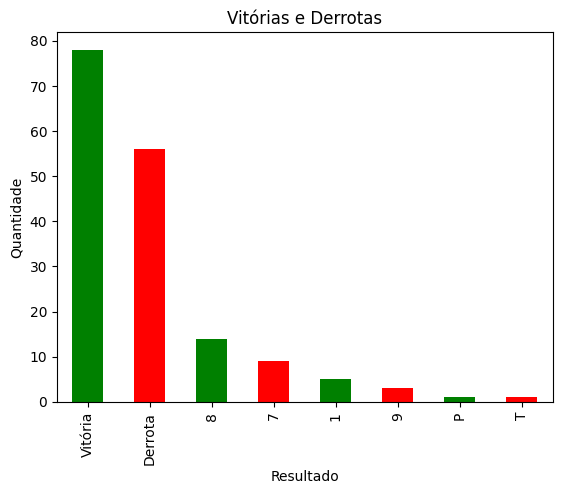

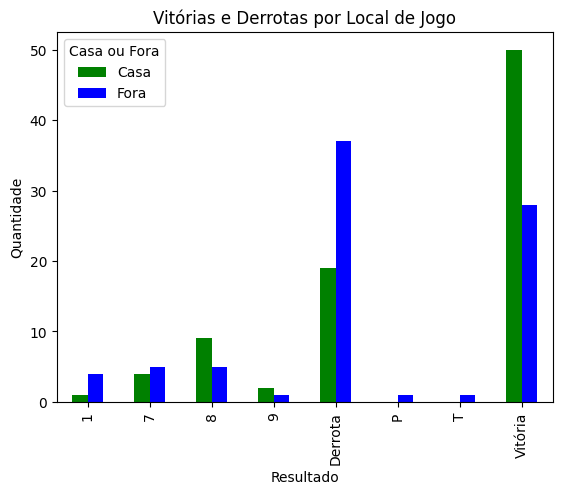

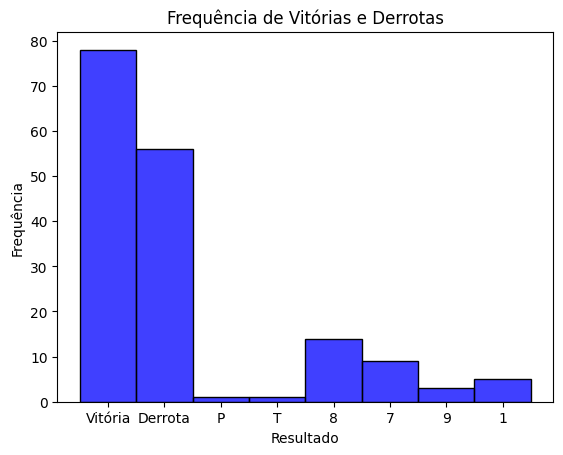

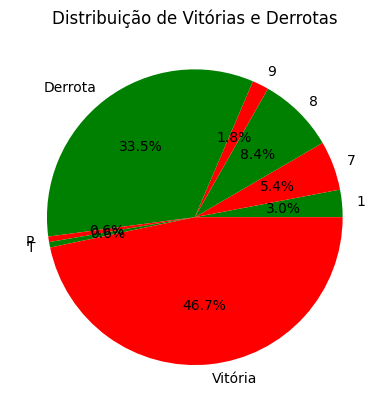

KeyError: 'Pontos Marcados'

In [69]:
#PRF8
def plot_nba_analysis(df_2024, df_2025):
    df = pd.concat([df_2024, df_2025])

    # Contagem de vitórias e derrotas
    win_loss_counts = df['Vitória ou Derrota'].value_counts()
    home_away_counts = df.groupby(['Vitória ou Derrota', 'Casa ou Fora']).size().unstack()

    # Gráfico de Barras Empilhado
    win_loss_counts.plot(kind='bar', color=['green', 'red'])
    plt.title("Vitórias e Derrotas")
    plt.xlabel("Resultado")
    plt.ylabel("Quantidade")
    plt.show()

    # Gráfico de Barras Agrupado
    home_away_counts.plot(kind='bar', color=['green', 'blue', 'red', 'brown'])
    plt.title("Vitórias e Derrotas por Local de Jogo")
    plt.xlabel("Resultado")
    plt.ylabel("Quantidade")
    plt.show()

    # Histograma
    sns.histplot(df['Vitória ou Derrota'], bins=2, color='blue')
    plt.title("Frequência de Vitórias e Derrotas")
    plt.xlabel("Resultado")
    plt.ylabel("Frequência")
    plt.show()

    # Gráfico de Pizza
    home_away_counts.sum(axis=1).plot.pie(autopct='%1.1f%%', colors=['green', 'red'])
    plt.title("Distribuição de Vitórias e Derrotas")
    plt.ylabel('')
    plt.show()

    # Gráfico de Radar
    categories = ['Pontos Marcados Casa', 'Pontos Sofridos Casa', 'Pontos Marcados Fora', 'Pontos Sofridos Fora']
    values = [df[df['Casa ou Fora'] == 'Casa']['Pontos Marcados'].mean(),
              df[df['Casa ou Fora'] == 'Casa']['Pontos Sofridos'].mean(),
              df[df['Casa ou Fora'] == 'Fora']['Pontos Marcados'].mean(),
              df[df['Casa ou Fora'] == 'Fora']['Pontos Sofridos'].mean()]

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.title("Média de Pontos Casa vs Fora")
    plt.show()

    # Gráfico de Linhas
    df['Jogo'] = range(1, len(df) + 1)
    sns.lineplot(data=df, x='Jogo', y='Vitória ou Derrota', marker='o')
    plt.title("Sequência de Vitórias e Derrotas")
    plt.xlabel("Jogo")
    plt.ylabel("Resultado")
    plt.show()

    # Gráfico de Dispersão
    sns.scatterplot(data=df, x='Adversário', y='Pontos Marcados', color='blue', label='Pontos Marcados')
    sns.scatterplot(data=df, x='Adversário', y='Pontos Sofridos', color='red', label='Pontos Sofridos')
    plt.xticks(rotation=90)
    plt.title("Pontos Marcados vs Sofridos por Adversário")
    plt.xlabel("Adversário")
    plt.ylabel("Pontos")
    plt.legend()
    plt.show()

# Chamando a função com os dataframes

plot_nba_analysis(df_transformado_2024, df_transformado_2025)
